In [1]:
## Import library yang dibutuhkan

# Modul yang berhubungan dengan manipulasi dan analisis data 
import pandas as pd 

# Modul yang berhubungan dengan pemrosesan teks
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Modul yang berhubungan dengan pemodelan dan evaluasi model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt

# Modul yang berhubungan dengan penyimpanan dan pengambilan objek Python
import pickle

In [2]:
# input dan menampilkan Dataset spam email yang akan diolah
## Label 0 = Ham dan 1 = Spam
df=pd.read_csv('Email.csv')
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


Melakukan pengecekan apakah ada nilai yang hilang pada Dataset 

In [3]:
# melakukan pengecekan pada setiap kolom apakah terdapat Nilai yang hilang
df.isnull().sum()

# Pada Kolom 'subject' terdapat 62 nilai yang hilang (NaN)
## Kode berikut digunakan digunakan untuk mengisi nilai-nilai yang hilang (NaN) dalam kolom 'subject'
df.fillna(df['subject'].mode().values[0],inplace=True)

In [4]:
# Lakukan pengecekan apakah masih terdapat nilai NaN pada kolom 'Subject, Message dan Label'
df.isnull().sum()

subject    0
message    0
label      0
dtype: int64

## Feature Engineering
Dilakukan untuk membuat fitur yang dapat meningkatkan kinerja model klasifikasi

In [5]:
# Untuk mempermudah klasifikasi body/massage digabungkan dengan Subject menjadi 1 kolom yang sama 
df['sub_mssg']=df['subject']+df['message']
df.head()

,subject,message,label,sub_mssg
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research centercontent...
1,sociolinguistics,"lang classification grimes , joseph e . and ba...",0,"sociolinguisticslang classification grimes , j..."
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...
3,risk,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...
4,request book information,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...


In [6]:
# Menghapus kolom 'subject'
df.drop('subject',axis=1,inplace=True)

In [7]:
df.head()

,message,label,sub_mssg
0,content - length : 3386 apple-iss research cen...,0,job posting - apple-iss research centercontent...
1,"lang classification grimes , joseph e . and ba...",0,"sociolinguisticslang classification grimes , j..."
2,i am posting this inquiry for sergei atamas ( ...,0,query : letter frequencies for text identifica...
3,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...
4,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...


Preprocessing Email :

1. *Case folding*

In [8]:
# Mengubah huruf kapital menjadi huruf kecil pada setiap kata yang ada pada dataset
df['sub_mssg']=df['sub_mssg'].str.lower()
df['sub_mssg'][0]

"job posting - apple-iss research centercontent - length : 3386 apple-iss research center a us $ 10 million joint venture between apple computer inc . and the institute of systems science of the national university of singapore , located in singapore , is looking for : a senior speech scientist - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise in computational linguistics , including natural language processing and * * english * * and * * chinese * * statistical language modeling . knowledge of state-of - the-art corpus-based n - gram language models , cache language models , and part-of - speech language models are required . a text - to - speech project leader - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - the successful candidate will have research expertise expertise in two or more of the following areas : computational linguistics , including natural language parsing , lexical database design , and statistical la

2. *Data Cleaning* 

In [9]:
#Setelah melakukan Case Folding selanjutnya melakukan Data Cleaning 
##Mengubah setiap Nomor/angka menjadi 'Numbers'
df['sub_mssg']=df['sub_mssg'].str.replace(r'\d+(\.\d+)?', 'numbers')

#Mengganti Baris berikutnya dengan 'WHITE SPACE'(menghapus karakter baris baru dan menggantikannya dengan karakter spasi, 
##Hal ini bertujuan untuk menjaga teks tetap dalam satu baris tanpa ada pemisahan oleh baris baru)
df['sub_mssg']=df['sub_mssg'].str.replace(r'\n'," ") 

#Mengganti ID Email dengan kata 'MAILID'
df['sub_mssg']=df['sub_mssg'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','MailID')

#Mengganti Link URLs menjadi kata 'Links'
df['sub_mssg']=df['sub_mssg'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','Links')

#Mengganti Tanda Mata uang dengan kata 'MONEY'
df['sub_mssg']=df['sub_mssg'].str.replace(r'£|\$', 'Money')

#Mengganti 'LARGE WHITE SPACE' menjadi 'SINGLE WHITE SPACE' 
##(bertujuan untuk menyederhanakan teks dan memastikan bahwa hanya ada satu WHITE SPACE di antara kata-kata atau elemen dalam teks)
df['sub_mssg']=df['sub_mssg'].str.replace(r'\s+', ' ')

#Menghapus setiap spasi diawal dan diakhis teks pada data
##(bertujuan untuk membersihkan teks dari spasi putih yang tidak diperlukan di awal atau akhir teks)
df['sub_mssg']=df['sub_mssg'].str.replace(r'^\s+|\s+?$', '')

#Mengganti Nomor Telepon menjadi 'Contact Number'
df['sub_mssg']=df['sub_mssg'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','contact number')

#Mengganti karakter khusus dengan 'WHITE SPACE'
##(Bertujuan untuk membersihkan teks dari karakter-karakter khusus yang tidak relevan atau tidak diinginkan)
df['sub_mssg']=df['sub_mssg'].str.replace(r"[^a-zA-Z0-9]+", " ")

C:\Users\Asus\AppData\Local\Temp\ipykernel_5532\220248317.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sub_mssg']=df['sub_mssg'].str.replace(r'\d+(\.\d+)?', 'numbers')
C:\Users\Asus\AppData\Local\Temp\ipykernel_5532\220248317.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sub_mssg']=df['sub_mssg'].str.replace(r'\n'," ")
C:\Users\Asus\AppData\Local\Temp\ipykernel_5532\220248317.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sub_mssg']=df['sub_mssg'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','MailID')
C:\Users\Asus\AppData\Local\Temp\ipykernel_5532\220248317.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sub_mssg']=df['sub_mssg'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','Links')
C:\Users\Asus\AppData\Local\Temp\ipykernel_5532\220248

In [10]:
df['sub_mssg'][0]

'job posting apple iss research centercontent length numbers apple iss research center a us Money numbers million joint venture between apple computer inc and the institute of systems science of the national university of singapore located in singapore is looking for a senior speech scientist the successful candidate will have research expertise in computational linguistics including natural language processing and english and chinese statistical language modeling knowledge of state of the art corpus based n gram language models cache language models and part of speech language models are required a text to speech project leader the successful candidate will have research expertise expertise in two or more of the following areas computational linguistics including natural language parsing lexical database design and statistical language modeling text tokenization and normalization prosodic analysis substantial knowledge of the phonology syntax and semantics of chinese is required knowl

In [11]:
df.head()

,message,label,sub_mssg
0,content - length : 3386 apple-iss research cen...,0,job posting apple iss research centercontent l...
1,"lang classification grimes , joseph e . and ba...",0,sociolinguisticslang classification grimes jos...
2,i am posting this inquiry for sergei atamas ( ...,0,query letter frequencies for text identificati...
3,a colleague and i are researching the differin...,0,riska colleague and i are researching the diff...
4,earlier this morning i was on the phone with a...,0,request book informationearlier this morning i...


3. *Tokenizing*

In [12]:
# Setelah Data Cleaning akan dilanjutkan ke proses Tokenizing
df['sub_mssg'] = df['sub_mssg'].str.replace(r'\s+', ' ')
df['sub_mssg'] = df['sub_mssg'].apply(lambda x: word_tokenize(x))

C:\Users\Asus\AppData\Local\Temp\ipykernel_5532\662481345.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sub_mssg'] = df['sub_mssg'].str.replace(r'\s+', ' ')


In [13]:
df['sub_mssg'][0]

['job',
 'posting',
 'apple',
 'iss',
 'research',
 'centercontent',
 'length',
 'numbers',
 'apple',
 'iss',
 'research',
 'center',
 'a',
 'us',
 'Money',
 'numbers',
 'million',
 'joint',
 'venture',
 'between',
 'apple',
 'computer',
 'inc',
 'and',
 'the',
 'institute',
 'of',
 'systems',
 'science',
 'of',
 'the',
 'national',
 'university',
 'of',
 'singapore',
 'located',
 'in',
 'singapore',
 'is',
 'looking',
 'for',
 'a',
 'senior',
 'speech',
 'scientist',
 'the',
 'successful',
 'candidate',
 'will',
 'have',
 'research',
 'expertise',
 'in',
 'computational',
 'linguistics',
 'including',
 'natural',
 'language',
 'processing',
 'and',
 'english',
 'and',
 'chinese',
 'statistical',
 'language',
 'modeling',
 'knowledge',
 'of',
 'state',
 'of',
 'the',
 'art',
 'corpus',
 'based',
 'n',
 'gram',
 'language',
 'models',
 'cache',
 'language',
 'models',
 'and',
 'part',
 'of',
 'speech',
 'language',
 'models',
 'are',
 'required',
 'a',
 'text',
 'to',
 'speech',
 'proje

4. *Stemming*

In [14]:
# import Stemmer untuk proses stemming
stemmer = PorterStemmer()
df['sub_mssg'] = df['sub_mssg'].apply(lambda x: [stemmer.stem(word) for word in x])

In [15]:
df['sub_mssg'][0]

['job',
 'post',
 'appl',
 'iss',
 'research',
 'centercont',
 'length',
 'number',
 'appl',
 'iss',
 'research',
 'center',
 'a',
 'us',
 'money',
 'number',
 'million',
 'joint',
 'ventur',
 'between',
 'appl',
 'comput',
 'inc',
 'and',
 'the',
 'institut',
 'of',
 'system',
 'scienc',
 'of',
 'the',
 'nation',
 'univers',
 'of',
 'singapor',
 'locat',
 'in',
 'singapor',
 'is',
 'look',
 'for',
 'a',
 'senior',
 'speech',
 'scientist',
 'the',
 'success',
 'candid',
 'will',
 'have',
 'research',
 'expertis',
 'in',
 'comput',
 'linguist',
 'includ',
 'natur',
 'languag',
 'process',
 'and',
 'english',
 'and',
 'chines',
 'statist',
 'languag',
 'model',
 'knowledg',
 'of',
 'state',
 'of',
 'the',
 'art',
 'corpu',
 'base',
 'n',
 'gram',
 'languag',
 'model',
 'cach',
 'languag',
 'model',
 'and',
 'part',
 'of',
 'speech',
 'languag',
 'model',
 'are',
 'requir',
 'a',
 'text',
 'to',
 'speech',
 'project',
 'leader',
 'the',
 'success',
 'candid',
 'will',
 'have',
 'research'

5. *Stopword*

In [16]:
# stopwords 
stop = stopwords.words('english')
df['Cleaned_Text'] = df['sub_mssg'].apply(lambda x: ' '.join([word for word in x if word not in stop]))

In [17]:
df['Cleaned_Text'][0]

'job post appl iss research centercont length number appl iss research center us money number million joint ventur appl comput inc institut system scienc nation univers singapor locat singapor look senior speech scientist success candid research expertis comput linguist includ natur languag process english chines statist languag model knowledg state art corpu base n gram languag model cach languag model part speech languag model requir text speech project leader success candid research expertis expertis two follow area comput linguist includ natur languag pars lexic databas design statist languag model text token normal prosod analysi substanti knowledg phonolog syntax semant chines requir knowledg acoust phonet speech signal process desir candid phd least number number year relev work experi technic msc degre least number number year experienc e veri strong softwar engin skill includ design implement product requir posit knowledg c c unix prefer unix c programm look experienc unix c p

In [18]:
# Menghapus Kolom Message 
df.drop('message',axis=1,inplace=True)

In [19]:
# Menghapus kolom Subject + Message
df.drop('sub_mssg',axis=1,inplace=True)

In [20]:
df.head()

,label,Cleaned_Text
0,0,job post appl iss research centercont length n...
1,0,sociolinguisticslang classif grime joseph e ba...
2,0,queri letter frequenc text identificationi pos...
3,0,riska colleagu research differ degre risk perc...
4,0,request book informationearli thi morn wa phon...


## Training Model

In [21]:
# Menggunakan 'TFIDF' untuk merubah teks menjadi representasi numerik dengan Metode 'TF-IDF'
tfidf = TfidfVectorizer(max_features=17000)

# Mendefinisikan X sebagai Teks yang sudah di PreProcessing dan Y sebagai Label
X = df.Cleaned_Text
Y = df.label

# Membagi data menjadi data Train (Latih), dan Test (Uji)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 225,stratify=Y)

# Melakukan Vektorisasi TF-IDF pada data Train dan Test
X_train_vectors = tfidf.fit_transform(X_train)
X_test_vectors = tfidf.transform(X_test)

In [22]:
# Mendapatkan kata-kata dengan nilai TF-IDF tertinggi dan sering muncul
feature_names = tfidf.get_feature_names()
top_features = []

# Looping untuk mendapatkan kata-kata dengan nilai TF-IDF tertinggi
for col in X_train_vectors.nonzero()[1]:
    if tfidf.idf_[col] > 1.0:  # Mengatur threshold TF-IDF yang diinginkan
        top_features.append((feature_names[col], tfidf.idf_[col]))

# Mengurutkan kata-kata berdasarkan nilai TF-IDF secara menurun
top_features = sorted(top_features, key=lambda x: -x[1])

c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [23]:
# Menampilkan beberapa hasil kata-kata dengan nilai TF-IDF tertinggi dan sering muncul
num_top_features = 10  # Jumlah kata-kata dengan nilai TF-IDF tertinggi yang ingin ditampilkan
seen_features = set()

for feature in top_features:
    if feature[0] not in seen_features:
        print(f"Kata: {feature[0]}, Nilai TF-IDF: {feature[1]}")
        seen_features.add(feature[0])
        num_top_features -= 1
        if num_top_features == 0:
            break

Kata: ludovik, Nilai TF-IDF: 8.05401778596039
Kata: vandevent, Nilai TF-IDF: 8.05401778596039
Kata: riadh, Nilai TF-IDF: 8.05401778596039
Kata: onlinenow, Nilai TF-IDF: 8.05401778596039
Kata: ameslan, Nilai TF-IDF: 8.05401778596039
Kata: mandrin, Nilai TF-IDF: 8.05401778596039
Kata: wiper, Nilai TF-IDF: 8.05401778596039
Kata: dishwash, Nilai TF-IDF: 8.05401778596039
Kata: jacaltec, Nilai TF-IDF: 8.05401778596039
Kata: igbo, Nilai TF-IDF: 8.05401778596039


In [24]:
# Menampilkan Jumlah data training dan testing
print("Jumlah data latih:", X_train_vectors.shape[0])
print("Jumlah data uji:", X_test_vectors.shape[0])

Jumlah data latih: 2314
Jumlah data uji: 579


In [25]:
# Mendefinisikan Model SVM 
svm = LinearSVC()
# Melakukan pelatihan model SVM dengan Data Train dan Test yang digabungkan
svm.fit(X_train_vectors, Y_train)
# Membuat prediksi pada Model
y_pred = svm.predict(X_test_vectors)

In [26]:
# Menghitung hasil evaluasi Model yang dilatih 
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

# Print hasil perhitungan evaluasi Model
print("Accuracy  : ", accuracy)
print("Precision : ", precision)
print("Recall    : ", recall)
print("F1-Score  : ", f1)

Accuracy  :  0.9930915371329879
Precision :  0.9893617021276596
Recall    :  0.96875
F1-Score  :  0.9789473684210526


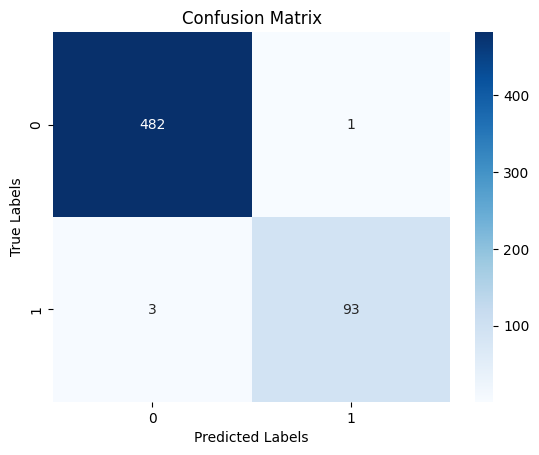

In [27]:
# Menghitung hasil evaluasi confusion matrix yang dilatih 
cm = confusion_matrix(Y_test, y_pred)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Menentukan label sumbu x dan y pada heatmap
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Menampilkan judul pada heatmap
plt.title("Confusion Matrix")

# Menampilkan grafik
plt.show()

In [28]:
# print hasil
print("Classification Report:")
print(classification_report(Y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       483
           1       0.99      0.97      0.98        96

    accuracy                           0.99       579
   macro avg       0.99      0.98      0.99       579
weighted avg       0.99      0.99      0.99       579



In [29]:
# Simpan model SVM dan TFIDF
pickle.dump(svm,open('ModelSVM.pkl','wb'))
pickle.dump(tfidf,open('TFIDF.pkl','wb'))